In [42]:
import scipy.io
import matplotlib.pyplot as plt
import math
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import numpy as np
import numpy.testing as testing
import cv2
from skimage import morphology, segmentation
from keras.layers import Cropping2D, ZeroPadding2D, Input

In [43]:
from matplotlib.colors import ListedColormap


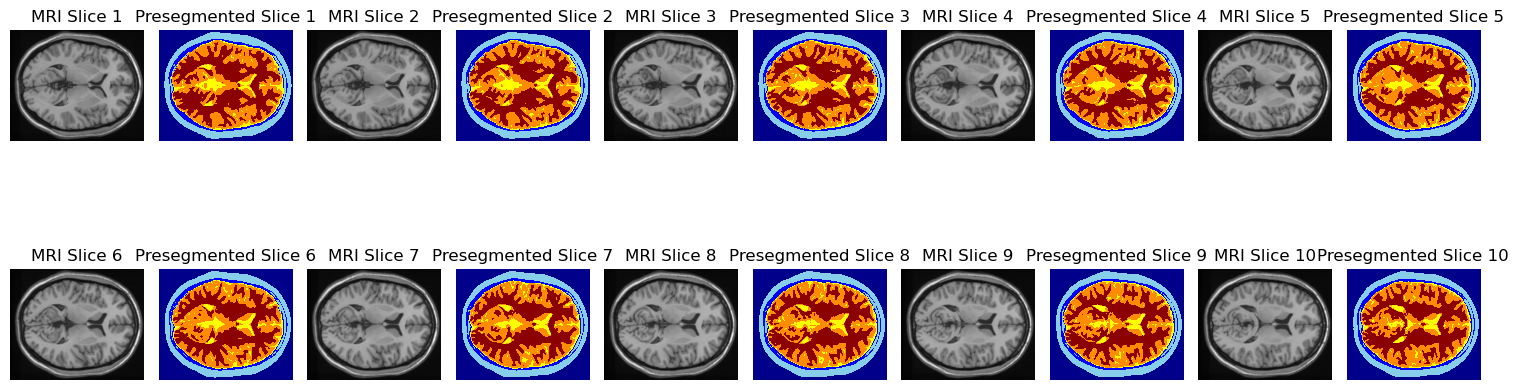

In [44]:

cmap = ListedColormap(['darkblue', 'skyblue', 'blue', 'yellow', 'darkorange', 'darkred'])
# Load the MATLAB file
mat_data = scipy.io.loadmat('Brain.mat')

# Extract the MRI slices and presegmented images
mri_slices = mat_data['T1']
segmented_slices = mat_data['label']


# Visualize the slices and corresponding presegmented images
num_slices = mri_slices.shape[2]

# Determine the number of columns and rows for subplots dynamically
max_columns = 5
num_rows = math.ceil(num_slices / max_columns)
num_columns = min(max_columns, num_slices)

fig, axes = plt.subplots(num_rows, num_columns * 2, figsize=(15, 6))

for i in range(num_slices):
    row_index = i // num_columns
    col_index = (i % num_columns) * 2

    ax_mri = axes[row_index, col_index]
    ax_seg = axes[row_index, col_index + 1]

    ax_mri.imshow(mri_slices[:, :, i], cmap='gray')
    ax_mri.set_title(f"MRI Slice {i+1}")
    ax_mri.axis('off')

    ax_seg.imshow(segmented_slices[:, :, i], cmap=cmap)
    ax_seg.set_title(f"Presegmented Slice {i+1}")
    ax_seg.axis('off')

# Hide any unused subplots
for i in range(num_slices, num_rows * num_columns):
    row_index = i // num_columns
    col_index = (i % num_columns) * 2
    axes[row_index, col_index].axis('off')
    axes[row_index, col_index + 1].axis('off')

plt.tight_layout()
plt.show()


In [45]:
slice_index = 0
image = mri_slices[:, :, slice_index]
segmented_ground_truth = segmented_slices[:, :, slice_index]
min_value = np.min(segmented_ground_truth)
max_value = np.max(segmented_ground_truth)
print(min_value)
print(max_value)
print(np.unique(segmented_ground_truth.flatten()))
print(image)
print(segmented_ground_truth)


0
5
[0 1 2 3 4 5]
[[ 6588.089   6468.3145  6707.863  ...  2515.764   2755.3125  2994.861 ]
 [ 7785.831   7905.6055  7666.057  ...  2994.861   3114.6353  3114.6353]
 [ 8264.928   8145.154   7905.6055 ...  2515.764   2875.0867  2875.0867]
 ...
 [ 7067.1855  6707.863   7186.96   ... 13774.544  14133.866  14493.189 ]
 [ 7666.057   7067.1855  7426.5083 ... 13175.673  14014.093  14253.641 ]
 [ 7186.96    6827.637   6947.4116 ... 11977.93   13175.673  14373.415 ]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [46]:
slice_index = 0
image = mri_slices[:, :, slice_index]
# Normalize the array
min_value = np.min(image)
max_value = np.max(image)
normalized_image = ((image - min_value) / (max_value - min_value)) *255
image = normalized_image
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image.astype(int))
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, num_markers = ndi.label(mask)

# Assuming you have your grayscale image array named 'image'
# Replace this with your actual array
image_uint8 = cv2.convertScaleAbs(normalized_image)
# Calculate Otsu's threshold
otsu_threshold, _ = cv2.threshold(image_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Adjust the threshold for segmenting into 6 regions
thresholds = np.linspace(otsu_threshold, image.max(), 6)
print(thresholds)

[ 75. 111. 147. 183. 219. 255.]


Threshold values: [ 75. 111. 147. 183. 219. 255.]


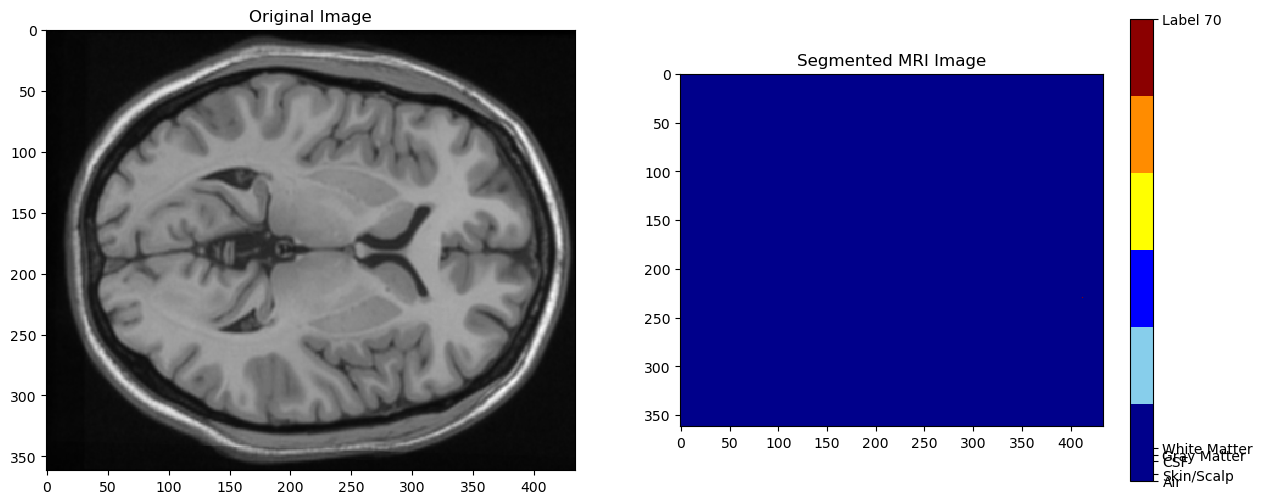

In [47]:


# Print the threshold values
print("Threshold values:", thresholds)

#print(normalized_image)
cmap = ListedColormap(['darkblue', 'skyblue', 'blue', 'yellow','darkorange','darkred' ])

# User-defined labels for markers
labels = {
    0: 'Air',
    1: 'Skin/Scalp',
    2: 'Skull',
    3: 'CSF',
    4: 'Gray Matter',
    5: 'White Matter'
}



markers[image <thresholds[0]] = 3
# Dark blue for label 0 = air
markers[(image >= thresholds[0]) & (image < thresholds[1])] = 1

# Light blue for label 1 = skin/scalp
markers[(image >= thresholds[1]) & (image < thresholds[2])] = 4

# Green for label 2 = skull
markers[(image >= thresholds[2]) & (image < thresholds[3])] = 5

# Yellow for label 3 =    
markers[(image >= thresholds[3]) & (image < thresholds[4])] = 5

# Yellow for label 3 =    
markers[(image >= thresholds[4]) & (image < thresholds[5])] = 5

markers[image >thresholds[5]] = 0



fig, axes = plt.subplots(1,  2, figsize=(15, 6))


segmented_image = watershed(-distance, markers, mask=image)


axes[0].imshow(image, cmap='gray', interpolation='nearest')
axes[0].set_title('Original Image')



# Add colorbar



# Add labels to the colorbar
unique_labels = np.unique(segmented_image)
label_names = [labels[i] if i in labels else f'Label {i}' for i in unique_labels]
ground_truth = segmented_slices[:, :, slice_index]
segmented_image_uint8 = np.uint8(segmented_image)

# Visualize the segmented image

axes[1].imshow(segmented_image, cmap=cmap, interpolation='nearest')

# Add a colorbar
colorbar = plt.colorbar(axes[1].imshow(segmented_image, cmap=cmap, interpolation='nearest'), ax=axes[1])
colorbar.set_ticks(np.unique(segmented_image))
colorbar.set_ticklabels(label_names)

axes[1].set_title('Segmented MRI Image')
plt.show()


In [48]:

def normalize_array(image):
    min_value = np.min(image)
    max_value = np.max(image)
    normalized_image = ((image - min_value) / (max_value - min_value))*255
    if max_value != 0:
        normalized_arr = normalized_image
    else:
        normalized_arr = image  # Handles case when max_value is 0 to avoid division by zero
    return normalized_arr
normalize_image = normalize_array(mri_slices[:,:, 3])
normalize_gt_image = normalize_array(segmented_slices[:,:, 3])
min_value_img = np.min(normalize_image)
max_value_img = np.max(normalize_image)


In [49]:
def watershed_segmentation_per_slice(index, mri_slices, segmented_slices):
    slice_index = index
    image = normalize_array(mri_slices[:, :, slice_index])

    
    distance = ndi.distance_transform_edt(image)
    coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image.astype(int))
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, num_markers = ndi.label(mask)


    # Assuming you have your grayscale image array named 'image'
    # Replace this with your actual array
    image_uint8 = cv2.convertScaleAbs(image)
    # Calculate Otsu's threshold
    blurred_image = cv2.GaussianBlur(image_uint8, (7, 7), 0)
    otsu_threshold, _ = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Adjust the threshold for segmenting into 6 regions
    thresholds = np.linspace(otsu_threshold, blurred_image.max(), 6)

    


    #print(normalized_image)

    cmap = ListedColormap(['darkblue', 'skyblue', 'blue', 'yellow','darkorange','darkred' ])

    # User-defined labels for markers
    labels = {
        0: 'Air',
        1: 'Skin/Scalp',
        2: 'Skull',
        3: 'CSF',
        4: 'Gray Matter',
        5: 'White Matter'
    }


    # Assign pre-defined markers


    markers[blurred_image <thresholds[0]] = 3
    # Dark blue for label 0 = air
    markers[(blurred_image >= thresholds[0]) & (blurred_image < thresholds[1])] = 1

    # Light blue for label 1 = skin/scalp
    markers[(blurred_image >= thresholds[1]) & (blurred_image < thresholds[2])] = 4

    # Green for label 2 = skull
    markers[(blurred_image >= thresholds[2]) & (blurred_image < thresholds[3])] = 5

    # Yellow for label 3 =    
    markers[(blurred_image >= thresholds[3]) & (blurred_image < thresholds[4])] = 5

    # Orange for label 4 = Gray Matter
    markers[(blurred_image >= thresholds[4]) & (blurred_image < thresholds[5])] = 2

    # Dark red for label 5 = White Matter
    markers[blurred_image == thresholds[5]] = 0
    
    #fig, axes = plt.subplots(num_rows, num_columns * 2, figsize=(15, 6))


    segmented_image = watershed(-distance, markers, mask=mask)
    #print(segmented_image)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    

    # Visualize the segmented image
    plt.figure(figsize=(8, 8))
    plt.imshow(segmented_image, cmap=cmap, interpolation='nearest')
    
    
    #Add colorbar
    
    plt.colorbar(ticks=np.unique(segmented_image))
    plt.clim(-0.5, 5.5)

    # Add labels to the colorbar
    unique_labels = np.unique(segmented_image)
    label_names = [labels[i] if i in labels else f'Label {i}' for i in unique_labels]
    
    plt.gca().set_yticklabels(label_names)
    plt.title('Segmented MRI Image')
    plt.show()
    
    
    ground_truth = segmented_slices[:, :, slice_index]
    
    # Visualize the segmented image
    plt.figure(figsize=(8, 8))
    plt.imshow(ground_truth, cmap=cmap, interpolation='nearest')
    
    
    #Add colorbar
    
    plt.colorbar(ticks=range(6), label='Tissue Layer')
    plt.clim(-0.5, 5.5)


    
    plt.gca().set_yticklabels(label_names)
    plt.title('Ground Truth Image')
    plt.show()
    
    
    
    segmented_image_uint8 = np.uint8(segmented_image)
    kernel_size = (3, 3)

    # Apply morphological closing to fill small gaps and smooth boundaries
    kernel_close = np.ones(kernel_size, np.uint8)
    closing = cv2.morphologyEx(segmented_image_uint8, cv2.MORPH_CLOSE, kernel_close)
    
    # Apply morphological opening to remove small noise or isolated regions
    kernel_open = np.ones(kernel_size, np.uint8)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel_open)
    
    
    # Optionally, apply additional morphological operations like dilation or erosion if needed
    #kernel_dilate = np.ones(kernel_size, np.uint8)
    #dilated = cv2.dilate(opening, kernel_dilate, iterations=1)

   

    #dice_coefficient_per_slice(ground_truth, opening)
    dice_coefficient = dice_coefficient_per_slice(ground_truth, opening)
    precision = precision_per_slice(ground_truth, opening)
    evaluation_metrices = []
    evaluation_metrices.append(dice_coefficient)
    evaluation_metrices.append(precision)
    return evaluation_metrices

In [50]:
def compute_binary_mask(image, tissue_label):
    binary_mask = np.where(image == tissue_label, 1, 0)

    return binary_mask




In [51]:
def dice_similarity_coefficient(ground_truth, segmented_image):
    intersection = np.sum(ground_truth & segmented_image)
    dice_coefficient = 0.0
    if np.sum(ground_truth) + np.sum(segmented_image) > 0:
        dice_coefficient_per_slice = (2.0 * intersection) / (np.sum(ground_truth) + np.sum(segmented_image))
    dice_coefficient = (2.0 * intersection) / (np.sum(ground_truth) + np.sum(segmented_image))
    return dice_coefficient


In [52]:
def precision(ground_truth, segmented_image):
    tp = np.sum((segmented_image == 1) & (ground_truth == 1))
    fp = np.sum((segmented_image == 1) & (ground_truth == 0))
    if (tp+fp) > 0:
        precision = tp / (tp + fp)
    else:
        precision = 0
        
    return precision

In [53]:
def dice_coefficient_per_slice(ground_truth, segmented_image):
    dice_coefficient_val = []
    num_tissues = 6
    max_columns = 6
    num_rows = math.ceil(num_tissues / max_columns)
    num_columns = min(max_columns, num_tissues)
  


    
    for i in range(0,6):
        binary_mask_gt = compute_binary_mask(ground_truth, i)
        binary_mask_segimg = compute_binary_mask(segmented_image, i)
        
        dice_coefficient_val.append(dice_similarity_coefficient(binary_mask_gt, binary_mask_segimg))




   
    dice_coefficient_per_slice = np.mean(dice_coefficient_val)
    
    return dice_coefficient_per_slice



In [54]:
def precision_per_slice(ground_truth, segmented_image):
    num_tissues = 6
    max_columns = 6
    num_rows = math.ceil(num_tissues / max_columns)
    num_columns = min(max_columns, num_tissues)
  
    precision_val = []

    
    
    for i in range(0,6):
        binary_mask_gt = compute_binary_mask(ground_truth, i)
        binary_mask_segimg = compute_binary_mask(segmented_image, i)
        
        
        precision_val.append(precision(binary_mask_gt, binary_mask_segimg))
        
   
    precision_per_slice = np.mean(precision_val)
    return precision_per_slice

In [55]:

def watershed_segmentation_for_dataset():
    mat_data = scipy.io.loadmat('Brain.mat')
    # Extract the MRI slices and presegmented images
    mri_slices = mat_data['T1']
    segmented_slices = mat_data['label']
    dice_coefficient_dataset = []
    precision_dataset = []
    evaluation_metrices_per_image = []
    for i in range(0,10):
        evaluation_metrices_per_image = watershed_segmentation_per_slice(i, mri_slices, segmented_slices)
        dice_coefficient_dataset.append(evaluation_metrices_per_image[0])
        precision_dataset.append(evaluation_metrices_per_image[1])
    print("Dice_coefficient for watershed algorithm: ", np.mean(dice_coefficient_dataset))
    print("Precision for watershed algorithm: ", np.mean(precision_dataset))

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


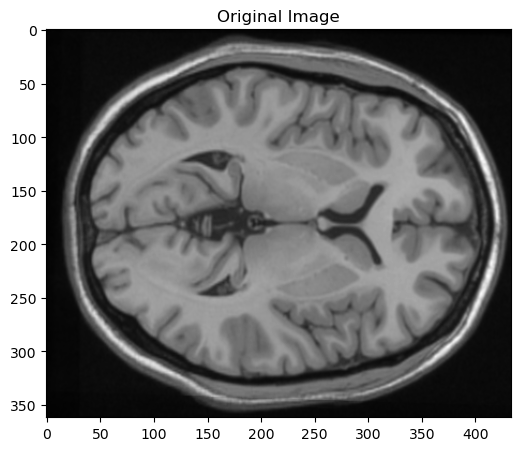

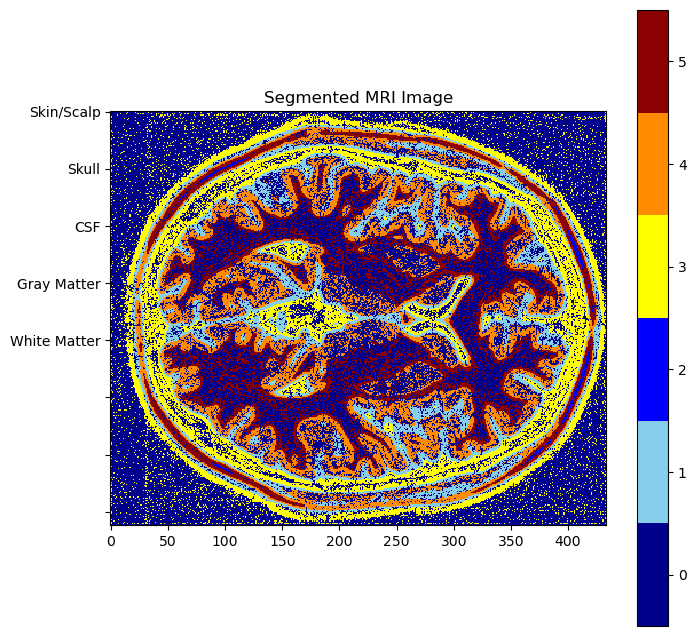

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


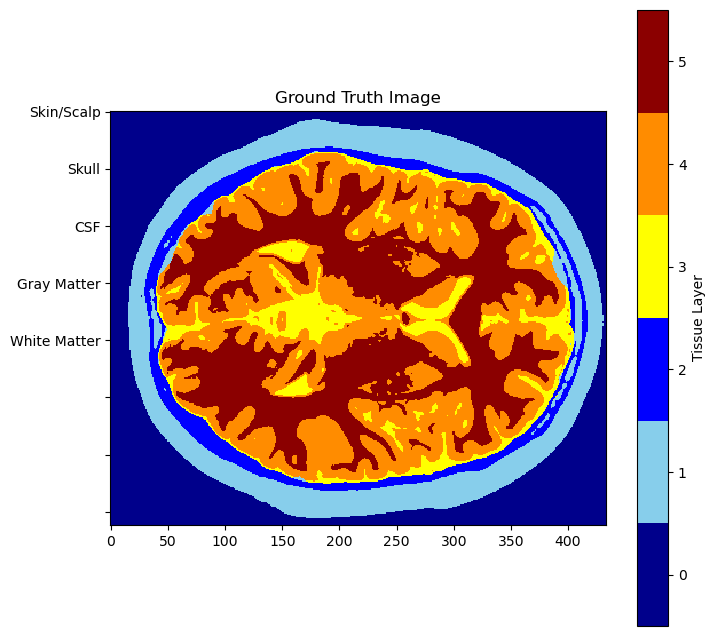

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


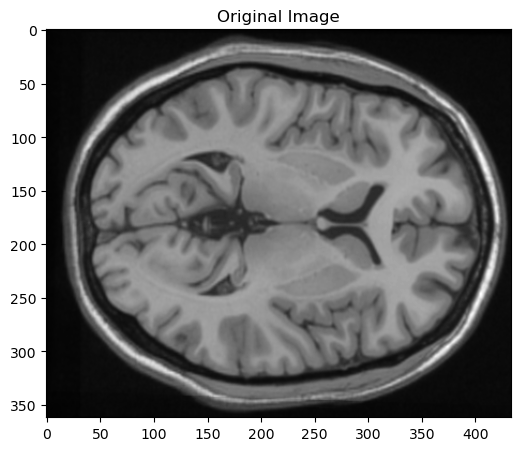

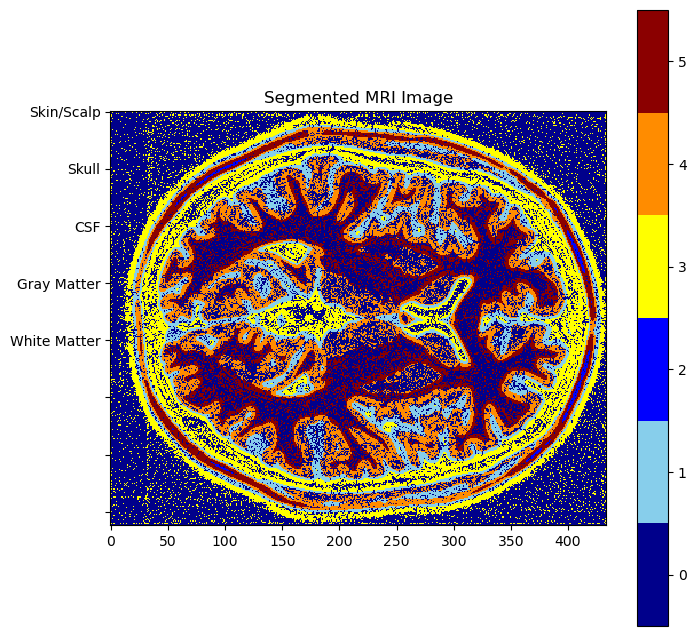

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


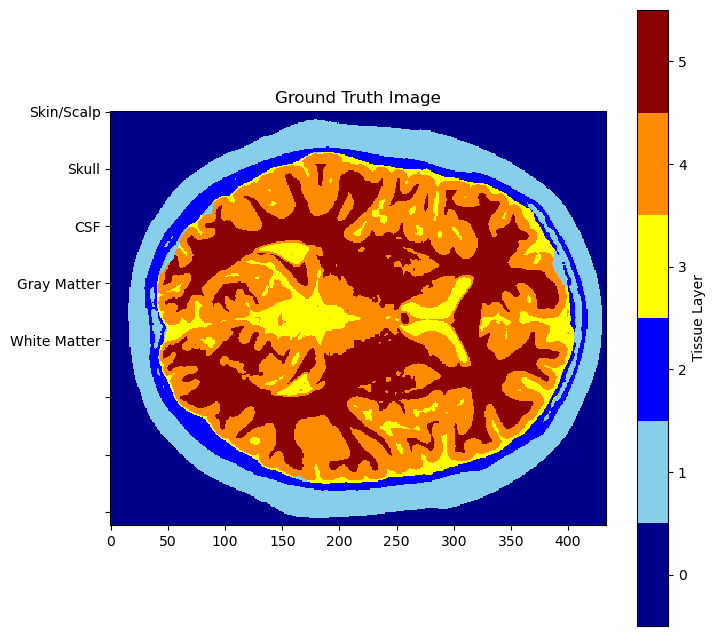

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


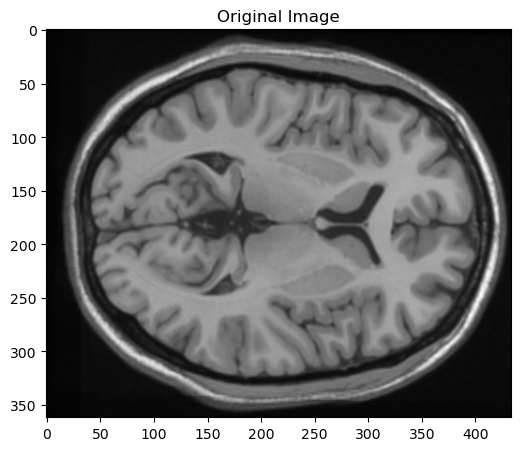

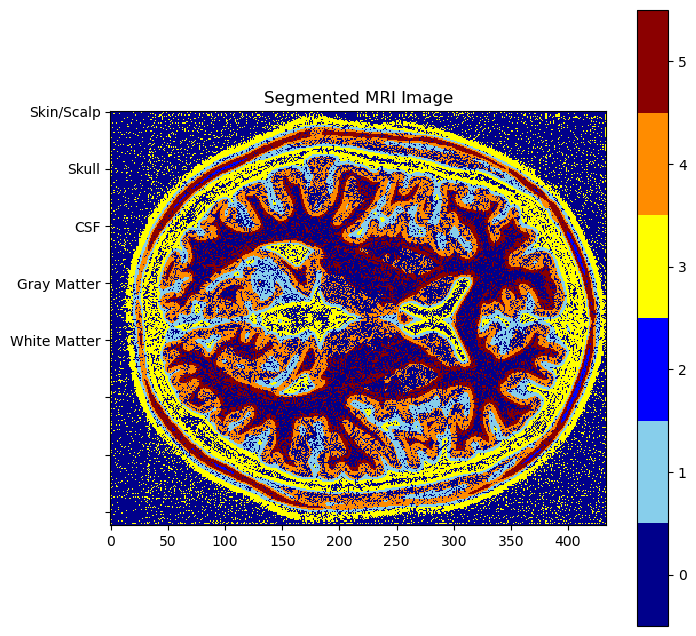

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


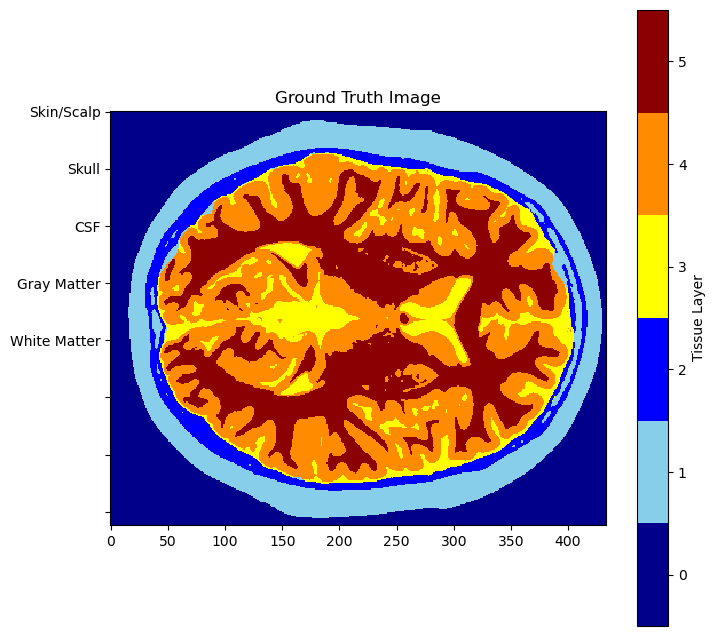

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


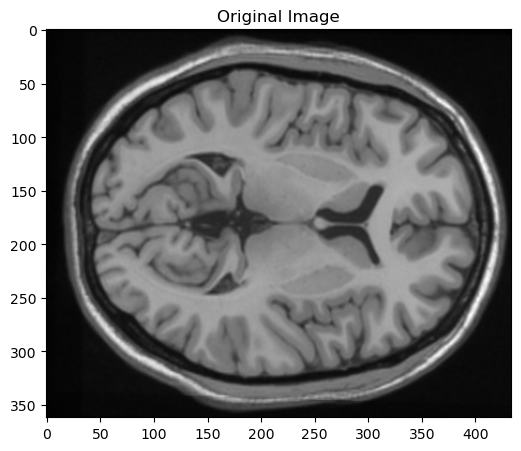

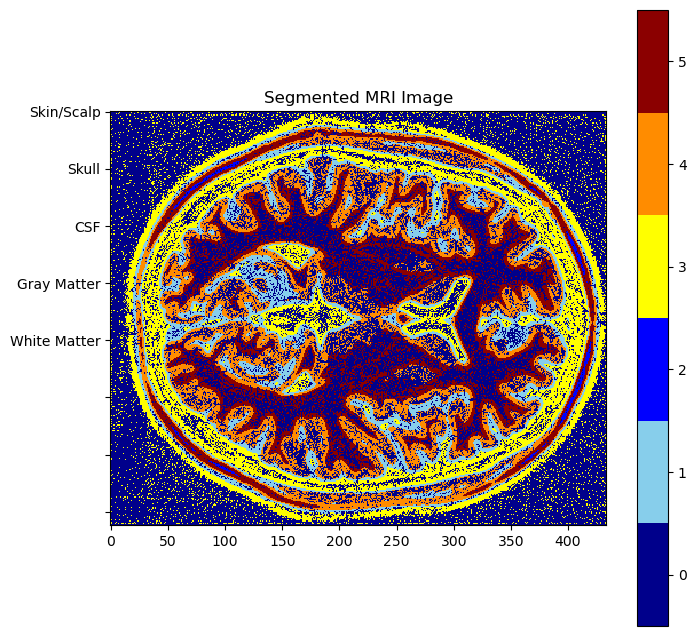

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


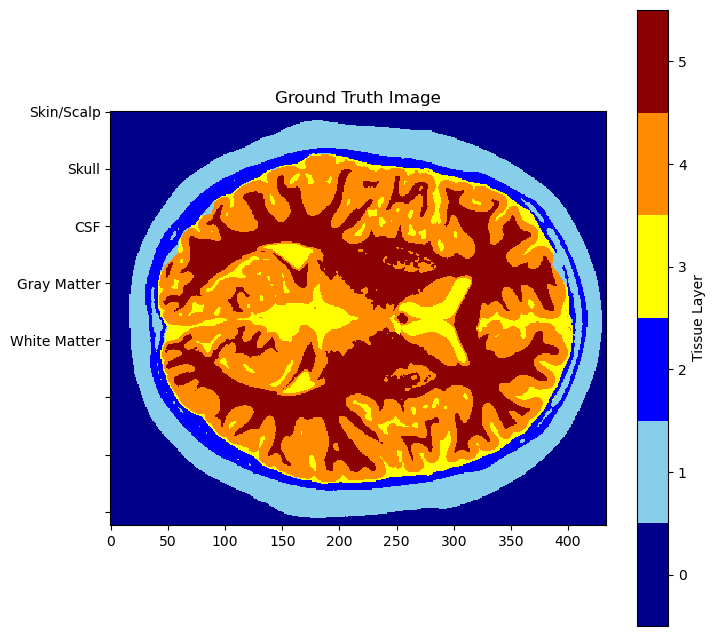

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


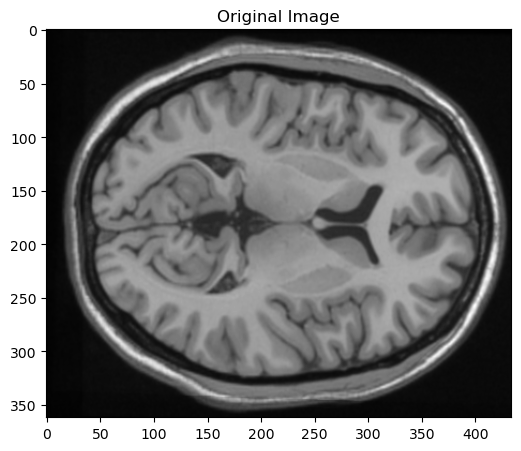

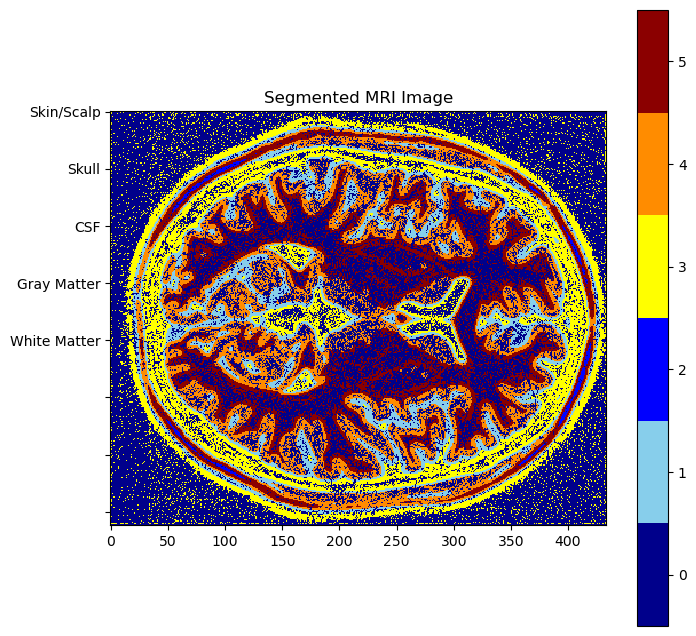

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


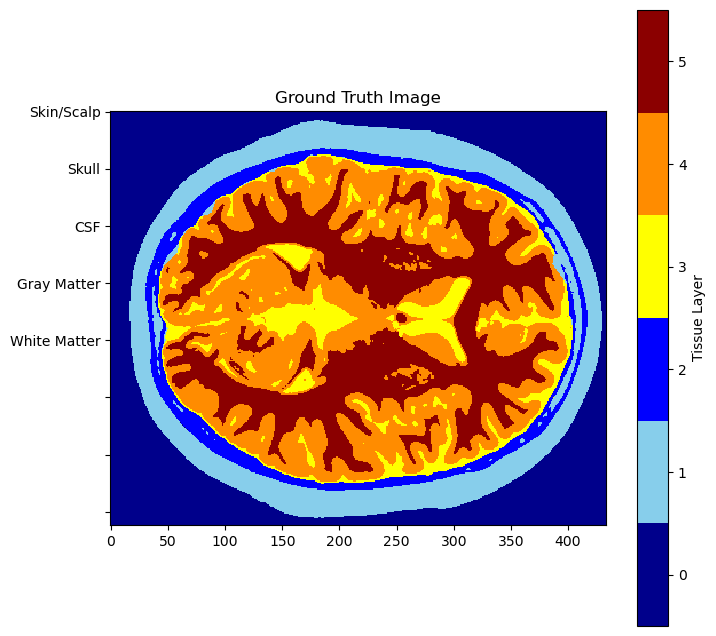

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


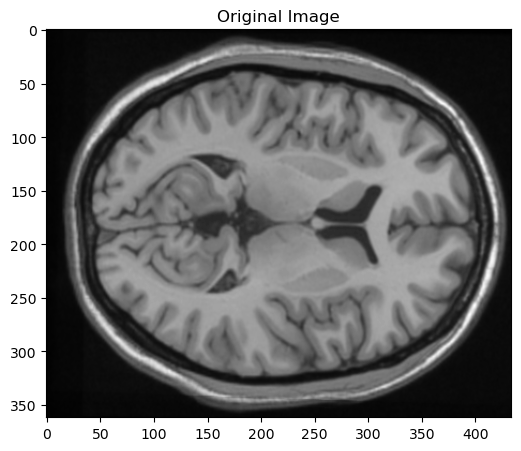

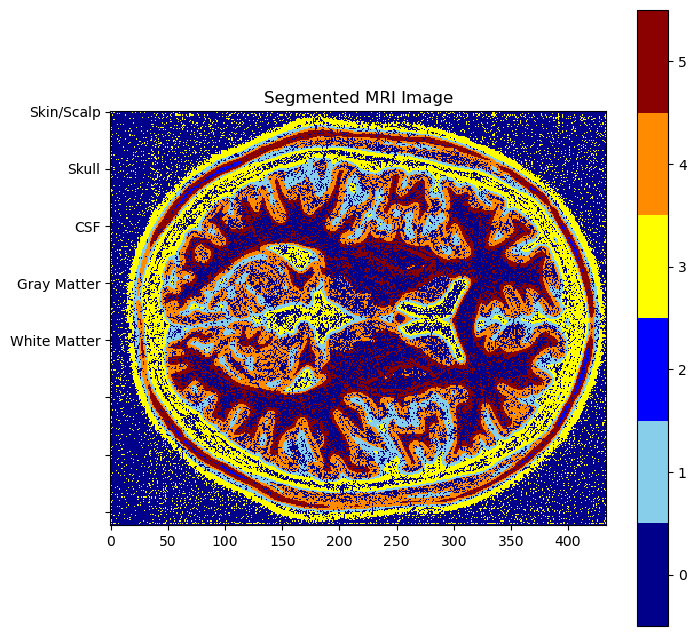

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


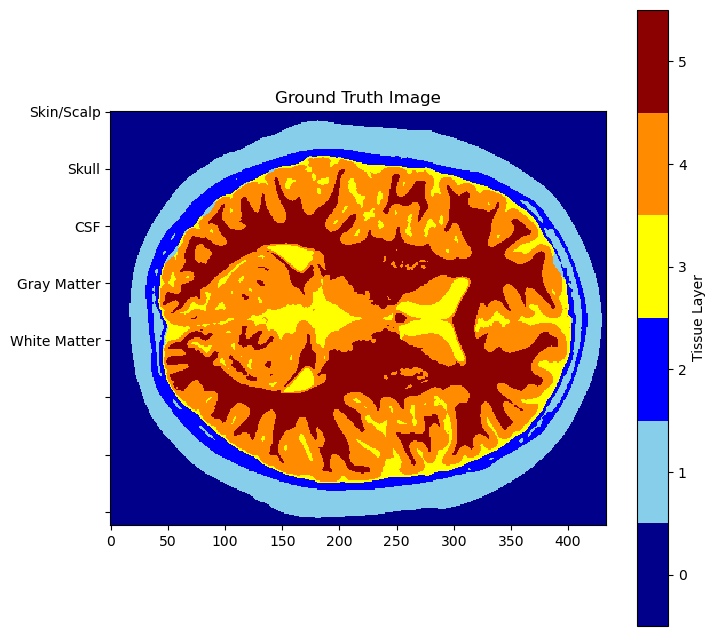

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


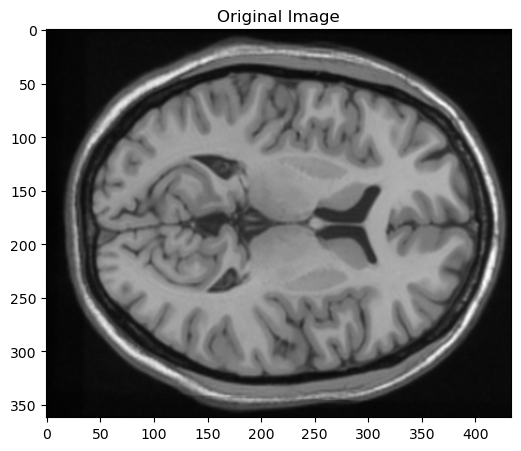

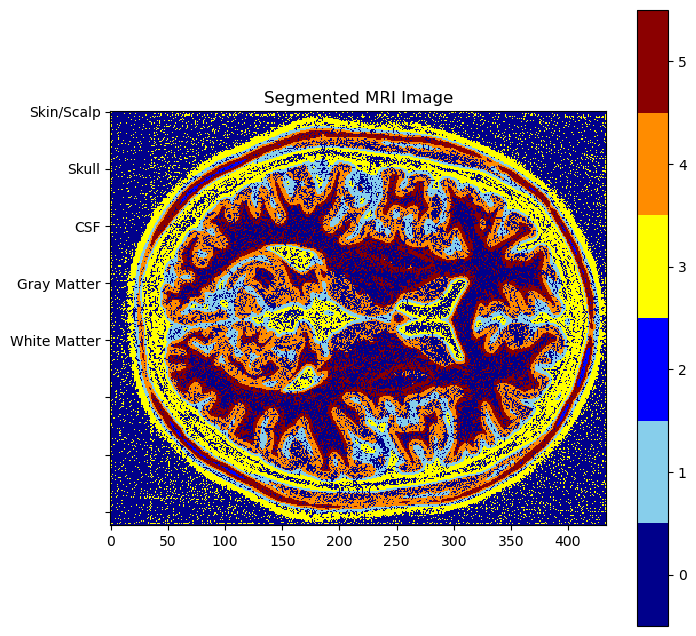

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


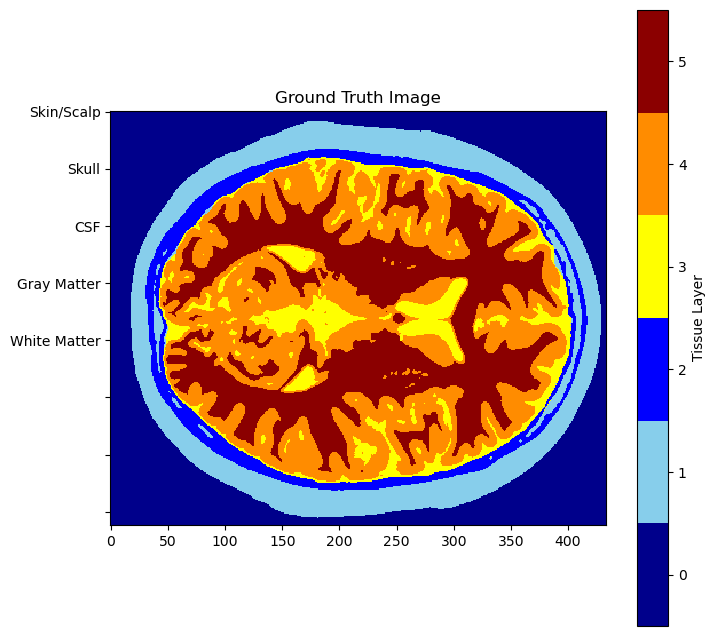

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


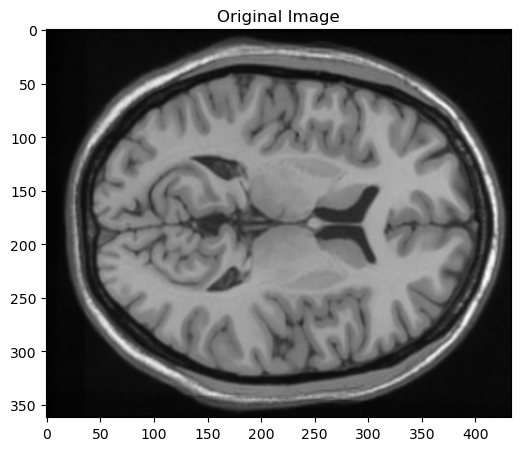

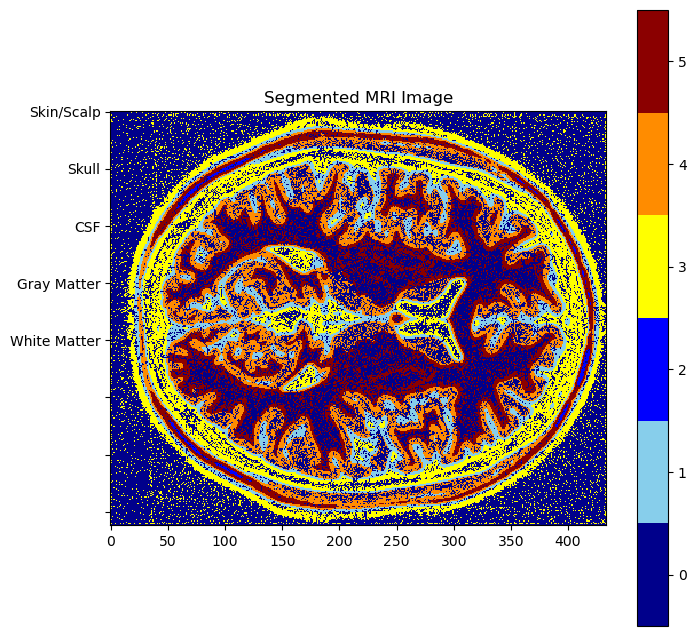

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


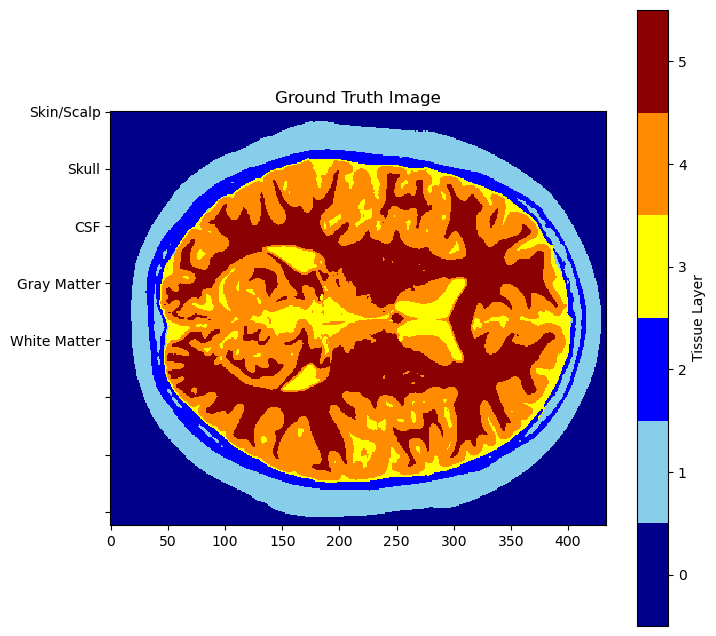

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


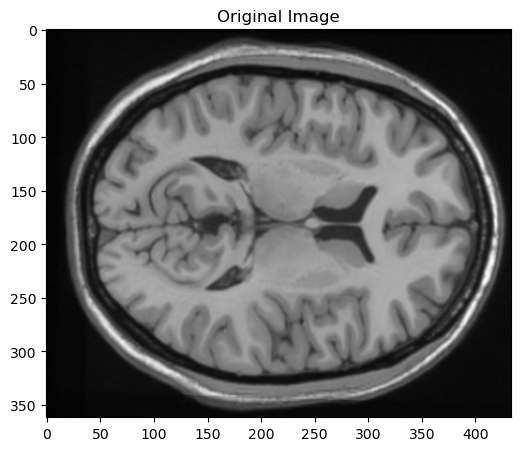

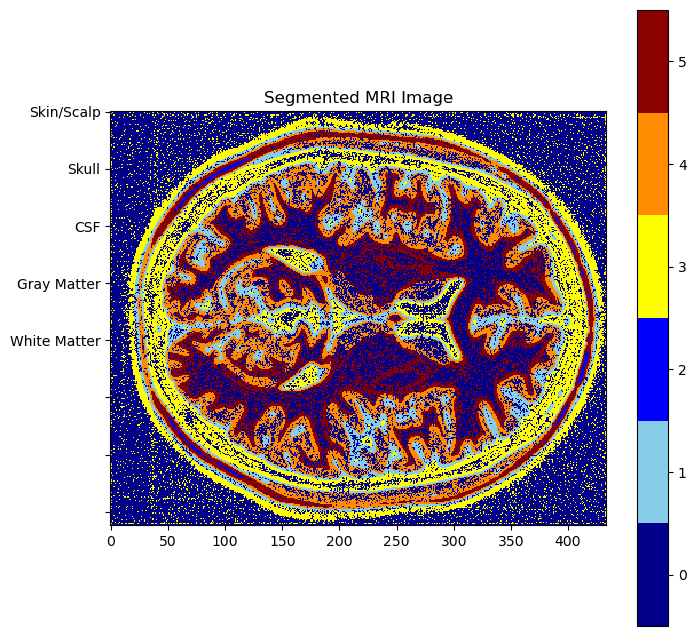

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


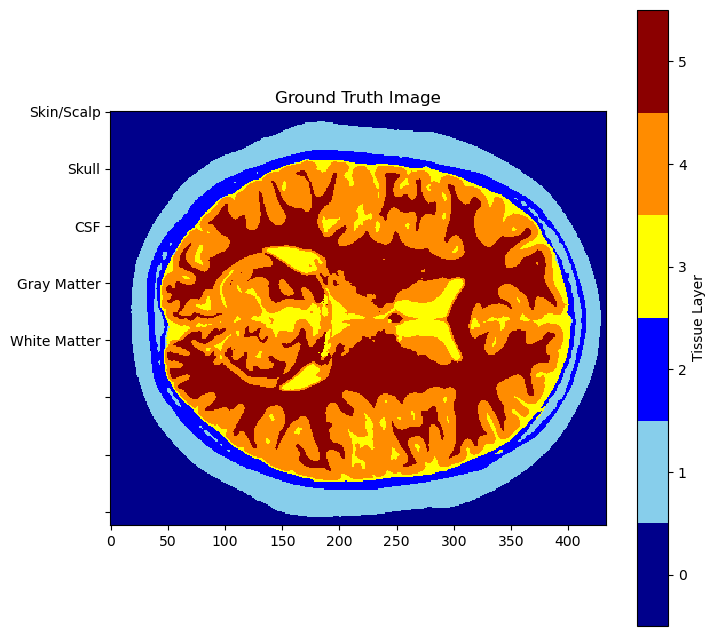

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


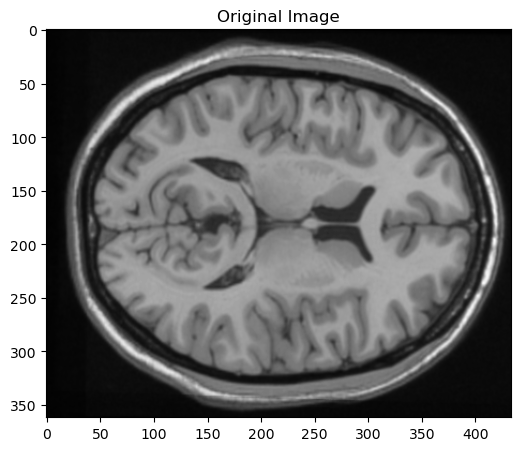

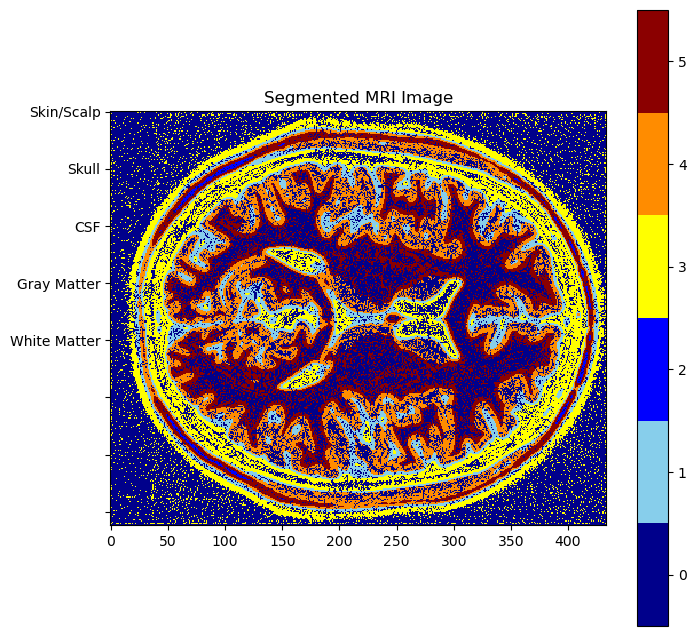

/var/folders/g9/hbn9851d54v_tl_jf_58lppw0000gn/T/ipykernel_71815/174153721.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(label_names)


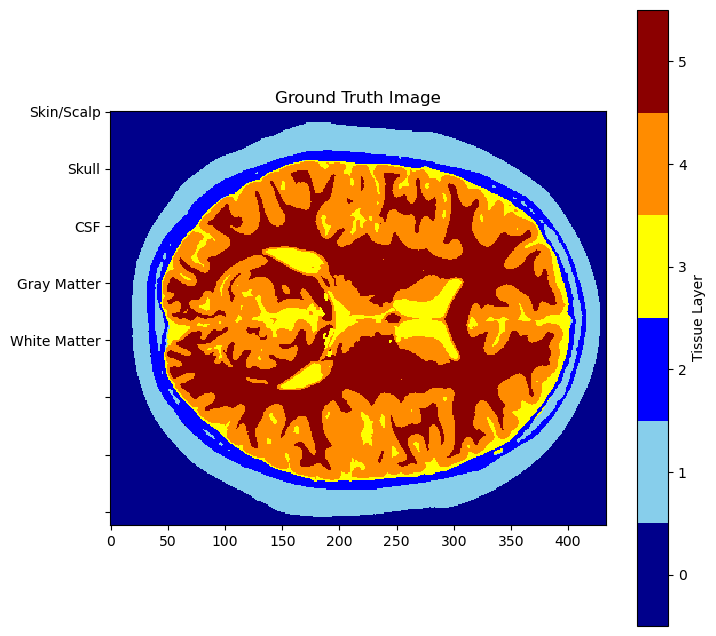

Dice_coefficient for watershed algorithm:  0.4608421044605526
Precision for watershed algorithm:  0.4666040510949939


In [56]:
watershed_segmentation_for_dataset()
